In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from physlite_events import physlite_events, get_branch_forms, get_lazy_form

In [2]:
%%time
#f = uproot.open("user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root")
filename = "/home/nikolai/data/user.elmsheus.21230205.EXT0._000002.DAOD_PHYSLITE.mc.pool.root"
tree = uproot.open(f"{filename}:CollectionTree")

CPU times: user 1.16 s, sys: 14.8 ms, total: 1.18 s
Wall time: 1.18 s


In [3]:
%%time
events = physlite_events(tree, verbose=True)

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
CPU times: user 386 ms, sys: 0 ns, total: 386 ms
Wall time: 386 ms


In [4]:
%%time
form = get_lazy_form(get_branch_forms(tree))

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
CPU times: user 80.6 ms, sys: 212 µs, total: 80.8 ms
Wall time: 80.1 ms


In [5]:
def has_overlap(obj1, obj2, filter_dr):
    """
    Return mask array where obj1 has overlap with obj2 based on a filter
    function on deltaR (and pt of the first one)
    """
    dr = obj1.delta_r(obj1.nearest(obj2))
    return ak.fill_none(filter_dr(dr, obj1.pt), False)


def match_dr(dr, pt, cone_size=0.2):
    return dr < cone_size


def match_boosted_dr(dr, pt, max_cone_size=0.4):
    return dr < np.minimum(*ak.broadcast_arrays(10000. / pt + 0.04, max_cone_size))

In [6]:
def muon_track_links(muons):
    return muons["inDetTrackParticleLink.m_persIndex"].mask[
        muons["inDetTrackParticleLink.m_persKey"] != 0
    ]

In [7]:
def jet_ghost_links(jets):
    return jets.GhostTrack.m_persIndex.mask[jets.GhostTrack.m_persKey != 0]

In [8]:
def is_associated(idx1, idx2):
    """
    Used for muon-jet ghost association
    """
    # TODO: check if keys also match
    xx1, xx2 = ak.unzip(ak.cartesian([idx1, idx2], nested=True))
    return ak.fill_none(ak.any(ak.any(xx1 == xx2, axis=-1), axis=-1), False)

In [9]:
def has_overlap_mujet(obj1, obj2, filter_dr):
    """
    Check if either ghost associated or delta_r match
    """
    if "GhostTrack" in obj1.fields:
        ghost_match = is_associated(jet_ghost_links(obj1), muon_track_links(obj2))
    else:
        ghost_match = is_associated(muon_track_links(obj1), jet_ghost_links(obj2))
    return (
        has_overlap(obj1, obj2, filter_dr)
        | ghost_match
    )

In [10]:
def mu_pflow_or_requirement(jets, muons):
    """
    Taken from this beautiful piece:
    https://gitlab.cern.ch/atlas/athena/-/blob/c8de5319c743b68e3e4935a5e34c7ccb8da778bf/PhysicsAnalysis/AnalysisCommon/AssociationUtils/Root/MuPFJetOverlapTool.cxx#L167
    I have no idea what's going on here ...
    """

    GeV = 1000.
    lowNtrk_x1 = 0.7
    lowNtrk_x2 = 0.85
    lowNtrk_y0 = 15. * GeV
    lowNtrk_y1 = 15. * GeV
    lowNtrk_y2 = 30. * GeV
    highNtrk_x1 = 0.6
    highNtrk_x2 = 0.9
    highNtrk_y0 = 5. * GeV
    highNtrk_y1 = 5. * GeV
    highNtrk_y2 = 30. * GeV
    numJetTrk = 4
    
    mu_id_pt = muons.id_pt
    mu_topoetcone40 = muons.topoetcone40
    
    nTrk = jets.NumTrkPt500_0
    sumTrkPt = jets.SumPtTrkPt500_0
    
    def requirements(x1, x2, y0, y1, y2):
        return (
            (mu_topoetcone40 < y0)
            | (mu_topoetcone40 < y0 + (y2 - y1) / (x2 - x1) * (mu_id_pt / sumTrkPt - x1))
            | (mu_id_pt / sumTrkPt > x2)
        )
    
    return ak.where(
        nTrk < numJetTrk,
        requirements(lowNtrk_x1, lowNtrk_x2, lowNtrk_y0, lowNtrk_y1, lowNtrk_y2),
        requirements(highNtrk_x1, highNtrk_x2, highNtrk_y0, highNtrk_y1, highNtrk_y2),
    )

In [11]:
def has_mu_pflow_overlap(jets, muons, cone_size=0.4):
    muons["id_pt"] = muons.trackParticle.pt
    jets["NumTrkPt500_0"] = ak.firsts(jets.NumTrkPt500, axis=-1)
    jets["SumPtTrkPt500_0"] = ak.firsts(jets.SumPtTrkPt500, axis=-1)
    jets_x, muons_x = ak.unzip(ak.cartesian([jets, muons], nested=True))
    return ak.any(
        mu_pflow_or_requirement(jets_x, muons_x) & (jets_x.delta_r(muons_x) < cone_size),
        axis=-1
    )

In [12]:
def get_obj_sel(evt):
    
    ## Object selection
    # ---------------------------------------------------------
    # TODO: sort jets

    # skip events without primary vertex (important for data)
    evt = evt[ak.num(evt.PrimaryVertices.x) > 0]

    # lepton selection
    evt["Electrons", "baseline"] = (
        (evt.Electrons.DFCommonElectronsLHLooseBL == 1)
        & (evt.Electrons.pt > 7000)
        & (np.abs(evt.Electrons.eta) < 2.47)
    )
    evt["Electrons", "signal"] = (
        evt.Electrons.baseline
        & (evt.Electrons.DFCommonElectronsLHTight == 1)
        & (evt.Electrons.topoetcone20 / evt.Electrons.pt < 0.2)
        & (evt.Electrons.ptvarcone20_TightTTVA_pt1000 / evt.Electrons.pt < 0.15)
    )
    evt["Muons", "baseline"] = (
        (~ak.is_none(evt.Muons.trackParticle, axis=1)) # require ID track
        & (evt.Muons.DFCommonGoodMuon == 1)
        & (evt.Muons.pt > 6000)
        & (np.abs(evt.Muons.eta) < 2.7)
    )
    evt["Muons", "signal"] = (
        evt.Muons.baseline
        & (np.abs(evt.Muons.eta) < 2.5)
        & (evt.Muons.topoetcone20 / evt.Muons.pt < 0.3)
        & (evt.Muons.ptvarcone30 / evt.Muons.pt < 0.15)
    )

    # jet selection
    evt["Jets", "baseline"] = evt.Jets.pt >= 20000
    jvt_pt_min = 20000
    jvt_pt_max = 60000
    jvt_eta_max = 2.4
    evt["Jets", "passJvt"] = (
        ((evt.Jets.pt >= jvt_pt_min) & (evt.Jets.pt < jvt_pt_max) & (evt.Jets.Jvt > 0.2) & (np.abs(evt.Jets.eta) < jvt_eta_max))
        | ((evt.Jets.pt >= jvt_pt_max) | (evt.Jets.pt < jvt_pt_min) | (np.abs(evt.Jets.eta) >= jvt_eta_max))
    )
    evt["Jets", "signal"] = evt.Jets.baseline & evt.Jets.passJvt & (np.abs(evt.Jets.eta) < 4.5)

    ## Overlap removal
    # --------------------------------------------------------------
    # run the funny MuPFlowJetOR procedure ...
    evt["Jets", "passOR"] = (
        evt.Jets.baseline
        & ~has_mu_pflow_overlap(evt.Jets, evt.Muons[evt.Muons.baseline])
    )
    # remove Jets overlapping with Electrons
    evt["Jets", "passOR"] = (
        evt.Jets.passOR
        & (
            ~has_overlap(
                evt.Jets,
                evt.Electrons[evt.Electrons.baseline],
                match_dr
            )
        )
    )
    # remove Electrons overlapping (boosted cone) with remaining Jets (if they pass jvt)
    evt["Electrons", "passOR"] = (
        evt.Electrons.baseline
        & (
            ~has_overlap(
                evt.Electrons,
                evt.Jets[evt.Jets.passOR & evt.Jets.passJvt],
                match_boosted_dr
            )
        )
    )
    # remove Jets overlapping with Muons (TODO: check ntrack requirement, ghost association)
    evt["Jets", "passOR"] = (
        evt.Jets.passOR
        & ~(
            has_overlap_mujet(evt.Jets, evt.Muons[evt.Muons.baseline], match_dr)
            & (evt.Jets.NumTrkPt500[:, :, 0] < 3)
        )
    )
    # remove Muons overlapping (boosted cone) with remaining Jets (if they pass jvt)
    evt["Muons", "passOR"] = (
        evt.Muons.baseline
        & (
            ~has_overlap_mujet(
                evt.Muons,
                evt.Jets[evt.Jets.baseline & evt.Jets.passOR & evt.Jets.passJvt],
                match_boosted_dr
            )
        )
    )
    return evt


In [13]:
%%time
evt_ak = get_obj_sel(events)

Loading part0-PrimaryVerticesAuxDyn.trackParticleLinks%offsets-offsets
Cache miss for  PrimaryVerticesAuxDyn.trackParticleLinks
Loading part0-AnalysisElectronsAuxDyn.trackParticleLinks%offsets-offsets
Cache miss for  AnalysisElectronsAuxDyn.trackParticleLinks
Loading part0-AnalysisElectronsAuxDyn.DFCommonElectronsLHLooseBL%content-data
Cache miss for  AnalysisElectronsAuxDyn.DFCommonElectronsLHLooseBL
Loading part0-AnalysisElectronsAuxDyn.pt%content-data
Cache miss for  AnalysisElectronsAuxDyn.pt
Loading part0-AnalysisElectronsAuxDyn.eta%content-data
Cache miss for  AnalysisElectronsAuxDyn.eta
Loading part0-AnalysisElectronsAuxDyn.DFCommonElectronsLHTight%content-data
Cache miss for  AnalysisElectronsAuxDyn.DFCommonElectronsLHTight
Loading part0-AnalysisElectronsAuxDyn.topoetcone20%content-data
Cache miss for  AnalysisElectronsAuxDyn.topoetcone20
Loading part0-AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA_pt1000%content-data
Cache miss for  AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA

Loading part0-AnalysisMuonsAuxDyn.topoetcone40%content-data
Cache miss for  AnalysisMuonsAuxDyn.topoetcone40
Loading part0-AnalysisMuonsAuxDyn.truthOrigin%content-data
Cache miss for  AnalysisMuonsAuxDyn.truthOrigin
Loading part0-AnalysisMuonsAuxDyn.truthParticleLink.m_persIndex%content-data
Cache miss for  AnalysisMuonsAuxDyn.truthParticleLink.m_persIndex
Loading part0-AnalysisMuonsAuxDyn.truthParticleLink.m_persKey%content-data
Cache miss for  AnalysisMuonsAuxDyn.truthParticleLink.m_persKey
Loading part0-AnalysisMuonsAuxDyn.truthType%content-data
Cache miss for  AnalysisMuonsAuxDyn.truthType


/home/nikolai/.conda/envs/py37/lib/python3.7/site-packages/awkward/_connect/_numpy.py:155: RuntimeWarning: divide by zero encountered in true_divide
  *[nplike.asarray(x) for x in inputs], **kwargs


Loading part0-AnalysisJetsAuxDyn.phi%content-data
Cache miss for  AnalysisJetsAuxDyn.phi
Loading part0-AnalysisElectronsAuxDyn.phi%content-data
Cache miss for  AnalysisElectronsAuxDyn.phi
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%offsets-offsets
Cache miss for  AnalysisJetsAuxDyn.GhostTrack
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%m_persKey%content-data
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%m_persIndex%content-data
CPU times: user 4.3 s, sys: 1.01 s, total: 5.31 s
Wall time: 4.4 s


In [14]:
from physlite_events import Factory, get_lazy_form, LazyGet

In [15]:
import json

In [16]:
form = json.dumps(get_lazy_form(get_branch_forms(tree)))

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


In [17]:
container = LazyGet(tree, verbose=True)

In [18]:
factory = Factory(form, tree.num_entries, container)

In [19]:
import timeit

In [20]:
def benchmark():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)

In [46]:
times = timeit.Timer(benchmark).repeat(number=1, repeat=5)

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


/home/nikolai/.conda/envs/py37/lib/python3.7/site-packages/awkward/_connect/_numpy.py:155: RuntimeWarning: divide by zero encountered in true_divide
  *[nplike.asarray(x) for x in inputs], **kwargs


Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


In [47]:
times, min(times)

([5.201907597998797,
  5.286271934000979,
  5.2070560960019066,
  5.259616054998332,
  5.248252514997148],
 5.201907597998797)

In [48]:
import time

In [49]:
def run_benchmark_no_overhead():
    times = []
    for i in range(5):
        tree = uproot.open(f"{filename}:CollectionTree")
        events = physlite_events(tree)
        start = time.time()
        get_obj_sel(events)
        duration = time.time() - start
        times.append(duration)
    return times, min(times)

In [50]:
run_benchmark_no_overhead()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


([3.8257579803466797,
  3.8050127029418945,
  3.7536356449127197,
  3.7540013790130615,
  3.8123700618743896],
 3.7536356449127197)

In [26]:
def run_benchmark_obj_sel():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)
    times = timeit.Timer(lambda: get_obj_sel(events)).repeat(number=1, repeat=5)
    return times, min(times)

In [51]:
run_benchmark_obj_sel()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


([1.1723876880023454,
  1.1747755770011281,
  1.1754699600023741,
  1.173013521998655,
  1.1736541610007407],
 1.1723876880023454)

In [28]:
loaded_keys = list(factory.container.cache.keys())

In [29]:
from deserialization_hacks import tree_arrays

In [30]:
def run_benchmark_preload():
    tree = uproot.open(f"{filename}:CollectionTree")
    cache = tree_arrays(tree, lambda branch: branch.name in loaded_keys)
    container = LazyGet(tree, verbose=False, cache=cache)
    form = json.dumps(get_lazy_form(get_branch_forms(tree)))
    return timeit.Timer(
        lambda: get_obj_sel(Factory(form, tree.num_entries, container).events)
    ).repeat(number=1, repeat=5)

In [52]:
run_benchmark_preload()

Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks


[3.8316211479977937,
 1.26996032599709,
 1.272076539000409,
 1.2652769940032158,
 1.2780639179982245]

In [32]:
# produced with athena + ST
# using https://gitlab.cern.ch/nihartma/enaf
def get_st_ntuple():
    f = uproot.open("/home/nikolai/code/enaf/run/ST_ntuple.root")
    tree = f["analysis"]
    keys = [k for k in tree.keys()]
    evt = ak.zip(
        {
            part[0].upper() + part[1:] + "s" : ak.zip(
                {k.split("_")[1] : tree[k].array() for k in keys if part in k}
            )
            for part in ["jet", "electron", "muon"]
        },
        depth_limit=1
    )
    # convert to bools
    bools = ["passOR", "passJvt", "baseline", "signal", "bad"]
    for part in evt.fields:
        for var in evt[part].fields:
            if var in bools:
                evt[part, var] = evt[part, var] == 1
    return evt

In [33]:
evt_st = get_st_ntuple()

In [34]:
df = []
for obj in ["Electrons", "Muons", "Jets"]:
    flags = ["all", "baseline", "passOR", "signal"]
    #if obj == "Jets":
    #    flags += ["passJvt"]
    for flag in flags:
        counts = []
        for e in [evt_ak, evt_st]:
            if flag != "all":
                counts.append(ak.count_nonzero(e[obj, flag]))
            else:
                counts.append(ak.sum(ak.num(e[obj])))
        entry = {
            "object" : obj,
            "flag" : flag,
            "athena/SUSYTools" : counts[1],
            "columnar analysis" : counts[0]
        }
        df.append(entry)
df = pd.DataFrame(df)

In [35]:
df.set_index(["object", "flag"])

athena/SUSYTools  columnar analysis
object    flag                                         
Electrons all                  23081              23081
          baseline             19219              19211
          passOR               18907              18898
          signal               14457              14623
Muons     all                  26475              26475
          baseline             22826              22914
          passOR               19455              19203
          signal               17453              17938
Jets      all                 524205             524205
          baseline            318948             318948
          passOR              296403             296414
          signal              298842             299005

In [36]:
df.set_index(["object", "flag"]).loc["Muons", "passOR"]

athena/SUSYTools     19455
columnar analysis    19203
Name: (Muons, passOR), dtype: int64

In [37]:
df.set_index(["object", "flag"]).loc["Jets", "passOR"]

athena/SUSYTools     296403
columnar analysis    296414
Name: (Jets, passOR), dtype: int64

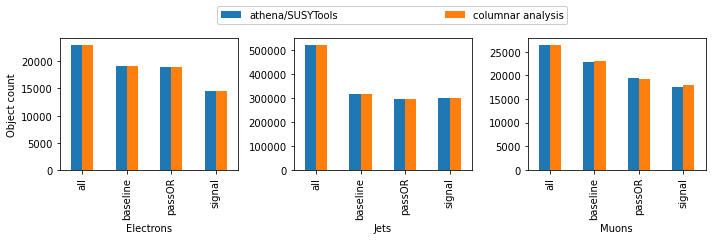

In [38]:
gb = df.groupby("object")
fig, axs = plt.subplots(figsize=(10, 3), ncols=len(gb), nrows=1)
for ax, group in zip(axs.ravel(), gb):
    group[1].pop("object")
    group[1].set_index("flag").plot(kind="bar", ax=ax, legend=False)
    ax.set_xlabel(group[0])
    if ax is axs[0]:
        ax.set_ylabel("Object count")
legend = fig.legend(
    *ax.get_legend_handles_labels(),
    framealpha=1,
    ncol=2,
    bbox_to_anchor=(0.3, 1.02, 0.5, .102),
    mode="expand",
)
fig.tight_layout()
fig.savefig("object_count_columnar_vs_st.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')

Loading part0-PrimaryVerticesAuxDyn.z%content-data
Cache miss for  PrimaryVerticesAuxDyn.z
Loading part0-CombinedMuonTrackParticlesAuxDyn.z0%content-data
Cache miss for  CombinedMuonTrackParticlesAuxDyn.z0


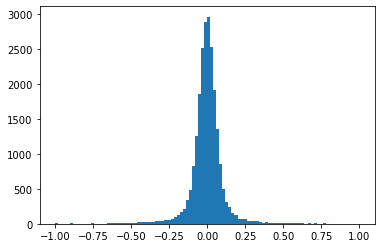

In [39]:
plt.hist(
    ak.flatten(ak.singletons(
        evt_ak.Muons[evt_ak.Muons.baseline].trackParticle.z0 - ak.firsts(evt_ak.PrimaryVertices.z)
    ), axis=None),
    bins=100, range=(-1, 1)
);

In [40]:
def overlay(selection, ax=None, **kwargs):
    ax = ax or plt.gca()
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_ak))), **kwargs)
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_st))), **kwargs)
    return ax

In [41]:
events.PrimaryVertices[:, 0].z

<Array [-46.9, 26.2, -35.8, ... -83.8, -4.79] type='50000 * float32'>

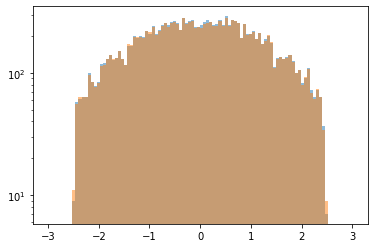

In [42]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

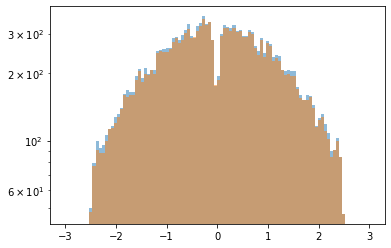

In [43]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

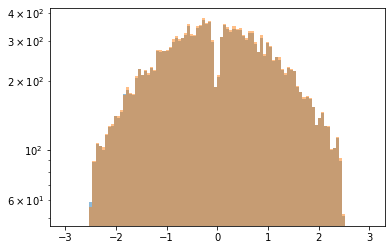

In [44]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.passOR].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

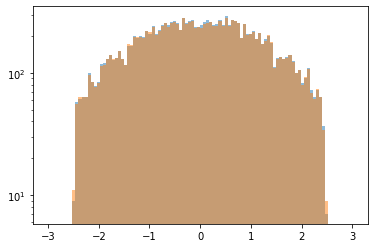

In [45]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")